In [215]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import math
import itertools
import datetime
#from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import joblib

# Read endogenous and exogenous data and filter country/dates

In [10]:
# We read the endogenous data (coronavirus data)

covid_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
covid = pd.read_csv(covid_url, parse_dates=['date'], index_col=['date'])

In [158]:
# We filter the country, dates and the variable to predict

country = 'Spain'
variable = 'new_cases'
initialdate = '01-01-2020'
enddate = '30-06-2020' 

# Filtering country and dates
covid_ctry = covid[covid['location']==country]
covid_ctry = covid_ctry.loc[initialdate:enddate]

# Making the data a daily series and applying 7-day rolling mean
covid_ctry_var = covid_ctry[variable]
#covid_ctry_var = covid_ctry_var.resample('D').sum()
covid_ctry_varR = covid_ctry_var.rolling(7).mean()

In [160]:
# We now read the exogenous data (for now, from a local file)

exogenous = pd.read_csv('./exogenas.csv', parse_dates=[0], index_col=[0])

In [161]:
# Exogenous data is already filtered by dates. We now need to filter the country:

exogenous_ctry = exogenous.loc[:, exogenous.columns.str.contains(country)]

# We apply the 7-day rolling mean, as in the endogenous data
exogenous_ctryR = exogenous_ctry.rolling(7).mean()

# Visualize endogenous and exogenous data and normalize it all

(182,) (182, 12)


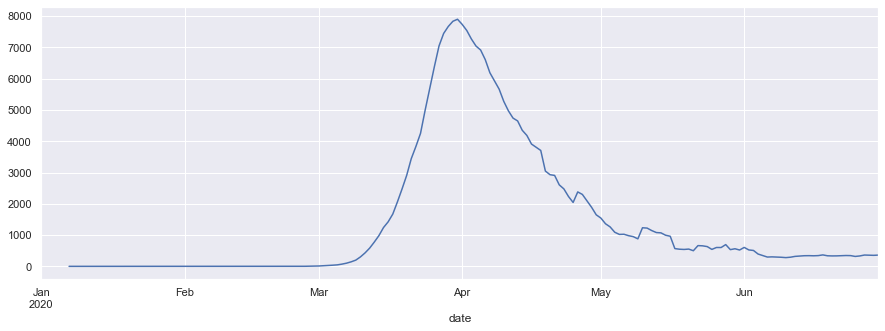

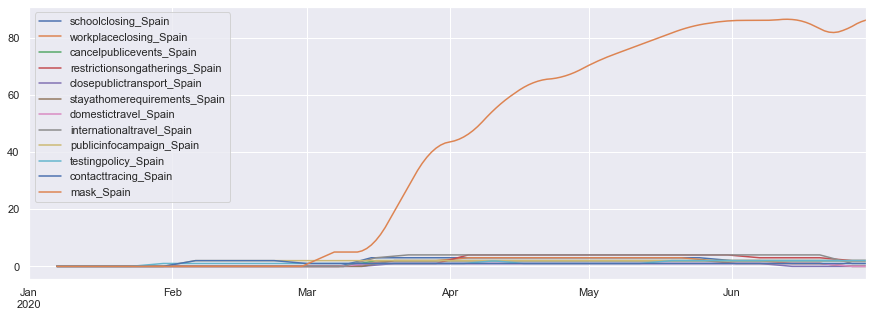

In [162]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [163]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [252]:
scaler_output.flatten()

array([           nan,            nan,            nan,            nan,
                  nan,            nan, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.80786058e-05,
       1.80786058e-05, 1.80786058e-05, 1.80786058e-05, 1.80786058e-05,
       1.80786058e-05, 1.80786058e-05, 0.00000000e+00, 0.00000000e+00,
       1.80786058e-05, 1.80786058e-05, 1.80786058e-05, 1.80786058e-05,
       1.80786058e-05, 1.80786058e-05, 1.80786058e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.80786058e-05,
      

In [265]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(covid_ctry_varR.values.reshape(-1,1))
scaler_output  = pd.Series(scaler_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.name)
y = scaler_output

(182,) (182, 12)


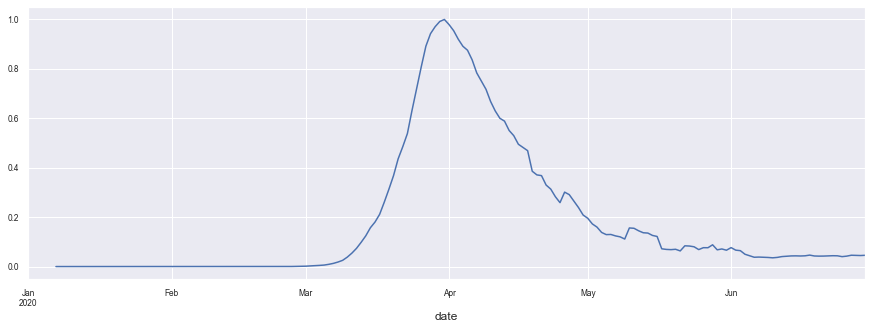

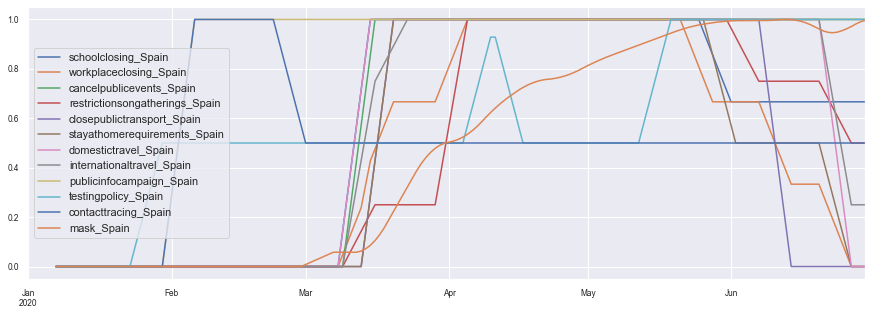

In [266]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [267]:
train_size = int(len(covid_ctry_varR) * 0.85)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size].dropna(), y[:train_size].dropna()
X_test, y_test = X[train_size:].dropna(), y[train_size:].dropna()

In [268]:
train_size, test_size

(154, 28)

In [269]:
(len(X_train) + 6) == train_size & (len(y_train) + 6) == train_size

True

In [270]:
len(X_test) == test_size & len(y_test) == test_size

True

# Stationarity: estimate differencing term (d)

In [271]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP: ', d_pp)

ADF:  2
KPSS:  1
PP:  1


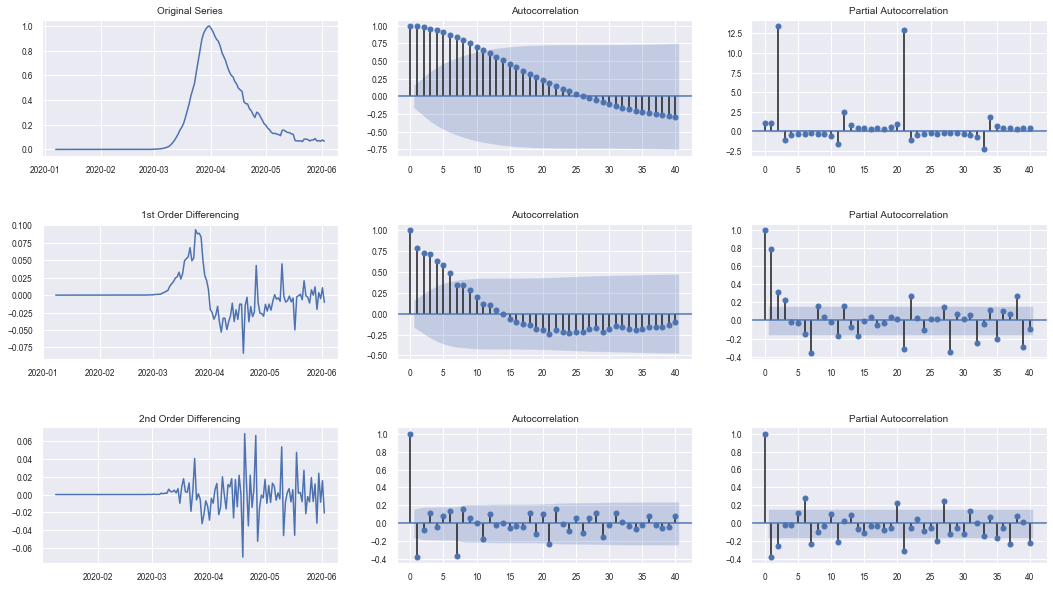

In [272]:
# Plotting ACF and PACF with the different 'd' values from previous step

plt.rcParams.update({'figure.figsize':(18,10), 'figure.subplot.hspace':0.5,
                     'xtick.labelsize':'x-small', 'ytick.labelsize':'x-small', 'axes.titlesize':'small'})
fig, axes = plt.subplots(3, 3)

# Original Series
axes[0, 0].plot(y_train); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(y_train, lags=40, ax=axes[0, 1])
sm.graphics.tsa.plot_pacf(y_train, lags=40, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(y_train.diff()); axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(y_train.diff().dropna(), lags=40, ax=axes[1, 1])
sm.graphics.tsa.plot_pacf(y_train.diff().dropna(), lags=40, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(y_train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(y_train.diff().diff().dropna(), lags=40, ax=axes[2, 1])
sm.graphics.tsa.plot_pacf(y_train.diff().diff().dropna(), lags=40, ax=axes[2, 2])
plt.show()
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

In [273]:
y_train.diff()

date
2020-01-07         NaN
2020-01-08    0.000000
2020-01-09    0.000000
2020-01-10    0.000000
2020-01-11    0.000000
                ...   
2020-05-29   -0.020411
2020-05-30    0.003580
2020-05-31   -0.005080
2020-06-01    0.010504
2020-06-02   -0.010214
Name: new_cases, Length: 148, dtype: float64

In [276]:
def test_stationarity(timeseries):

    # Determining rolling statistics
    rolling_mean = timeseries.rolling(window=3).mean()
    rolling_std = timeseries.rolling(window=3).std()

    # Plot rolling statistics

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Result of Dicky=Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

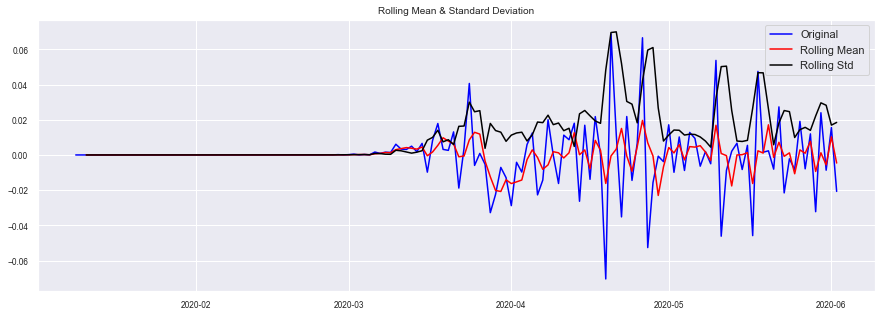

Result of Dicky=Fuller Test
Test Statistic           -4.184302
p-value                   0.000700
#Lags Used               10.000000
#Observations Used      135.000000
Critical Value (1%)      -3.479743
Critical Value (5%)      -2.883198
Critical Value (10%)     -2.578320
dtype: float64


In [280]:
test_stationarity(y_train.diff().diff().dropna())

**We think d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1 which is an indication that the series is being over-differenced**

# Estimate order p and q of ARIMA model, using auto_arima

Fit ARIMA(0,1,0)x(0,0,0,1) [intercept=True]; AIC=-682.206, BIC=-640.340, Time=0.392 seconds
Fit ARIMA(0,1,1)x(0,0,0,1) [intercept=True]; AIC=-734.565, BIC=-689.709, Time=0.484 seconds
Fit ARIMA(0,1,2)x(0,0,0,1) [intercept=True]; AIC=-741.995, BIC=-694.148, Time=0.509 seconds
Fit ARIMA(0,1,3)x(0,0,0,1) [intercept=True]; AIC=-758.973, BIC=-708.136, Time=0.557 seconds
Fit ARIMA(0,1,4)x(0,0,0,1) [intercept=True]; AIC=-764.457, BIC=-710.629, Time=0.554 seconds
Fit ARIMA(0,1,5)x(0,0,0,1) [intercept=True]; AIC=-770.650, BIC=-713.832, Time=0.636 seconds
Fit ARIMA(1,1,0)x(0,0,0,1) [intercept=True]; AIC=-771.183, BIC=-726.327, Time=0.423 seconds
Fit ARIMA(1,1,1)x(0,0,0,1) [intercept=True]; AIC=-788.944, BIC=-741.097, Time=0.504 seconds
Fit ARIMA(1,1,2)x(0,0,0,1) [intercept=True]; AIC=-785.842, BIC=-735.005, Time=0.511 seconds
Fit ARIMA(1,1,3)x(0,0,0,1) [intercept=True]; AIC=-795.171, BIC=-741.344, Time=0.602 seconds
Fit ARIMA(1,1,4)x(0,0,0,1) [intercept=True]; AIC=-784.252, BIC=-727.434, Time=0.

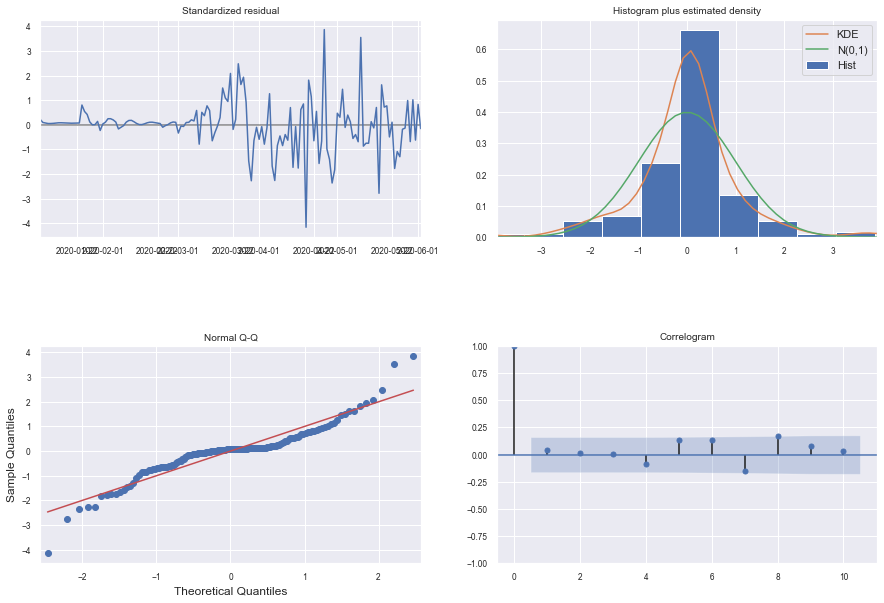

In [295]:
modelauto7 = pm.auto_arima(y_train, exogenous=X_train, start_p=1, start_q=1,
                    #  test='adf',       # use kpss to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                    #  m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                    # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(modelauto7.summary())
modelauto7.plot_diagnostics(figsize=(15,10))
plt.show()